# Publishing rate analysis

[The Research Productivity of New PhDs in Economics: The Surprisingly High Non-success of the Successful](https://www.aeaweb.org/articles?id=10.1257/jep.28.3.205)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as tt
import pymc3 as pm
import arviz as az

sns.set_palette("husl")

In [2]:
# Switch to the fake data if you don't have access to the real data.
# raw_data = pd.read_csv("fake_data/fake_data.csv")
raw_data = pd.read_excel("raw_data/data/Conley_Onder_JEPdata.xlsx")

## Visualize

Let's visualize the data first to get an idea of what we're modelling.

TypeError: distplot() got an unexpected keyword argument 'legend'

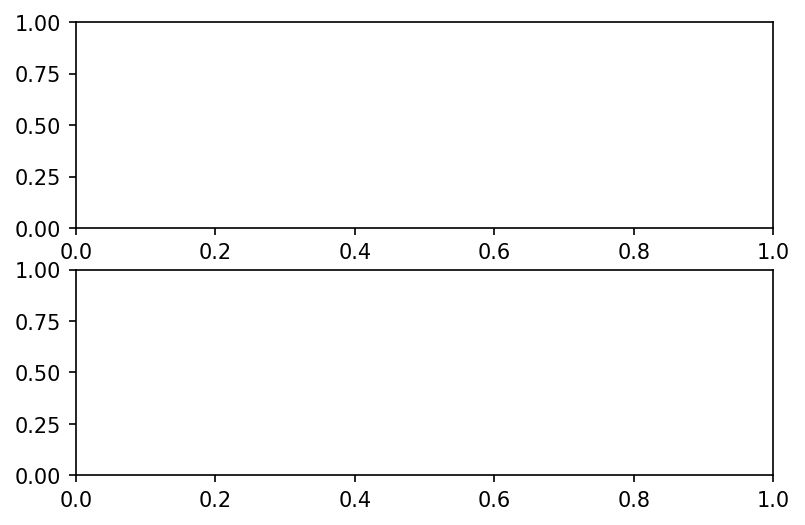

In [24]:
fig, ax = plt.subplots(2,1,figsize=(6,4))
fig.set_dpi(150)

# sns.kdeplot(raw_data.AERPub, alpha=0.4, ax=ax[0]);
kwargs = {"size": 0.1}
for i in range(5):
    sns.distplot(raw_data[raw_data.Rank == i].AERPub, ax=ax[0], legend=False);